In [1]:
#bert embedding models 
#using random sample dataset 

from math import ceil

from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, LSTM, GRU, Masking, TimeDistributed, BatchNormalization
from keras.layers import Concatenate, Reshape, Bidirectional, Softmax, LocallyConnected1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses
from keras.utils import plot_model
import tensorflow as tf

import pandas as pd

import math

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm


from contextlib import redirect_stdout

import pickle
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
#simple concantenation model (concatenates inputs)
def simple_subtract_model(layer1Size, layer2Size):
    #Inputs
    res_1 = Input(shape=(3800,))
    res_2 = Input(shape=(3800,))

    #Outputs
    true_interacts = Input(shape=(1,))
    
    #layers 
    layer_dense_pair_1 = Dense(layer1Size, activation='relu')
    layer_dense_pair_2 = Dense(layer2Size, activation = 'relu')
    pred_layer = Dense(1, activation='sigmoid', kernel_initializer='zeros')
    
    #network
    diff_res = keras.layers.Subtract()([res_1, res_2])
    dense_out_pair1 = layer_dense_pair_1(diff_res) #try subtracting two input reps 
    dense_out_pair2 = layer_dense_pair_2(dense_out_pair1)
    pred_interacts = pred_layer(dense_out_pair2)

    interaction_model = Model(
        inputs=[
            res_1,
            res_2
        ],
        outputs=pred_interacts
    )
    interaction_loss = Lambda(sigmoid_nll, output_shape = (1,))([true_interacts, pred_interacts])

    loss_model = Model(
        [
            res_1,
            res_2,
            true_interacts
        ],
        interaction_loss
    )
    return interaction_model, loss_model



def sigmoid_nll(inputs) :
    y_true, y_pred = inputs
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return K.mean(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred), axis=-1)


def mean_squared_error(inputs) :
    y_true, y_pred = inputs
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mean_absolute_error(inputs) :
    y_true, y_pred = inputs
    return K.mean(K.abs(y_pred - y_true), axis=-1)

def logcosh(inputs) :
    y_true, y_pred = inputs
    def _logcosh(x):
        return x + K.softplus(-2. * x) - K.log(2.)
    return K.mean(_logcosh(y_pred - y_true), axis=-1)

In [3]:
#set up generators - must open the correct npy files and return them from the bert_folder 

def setupDataframesForGenerators(data):
    #break up by train/valid/test splits already outlined in DF 
    train = data[data['Dataset'] == 'Train'].copy().reset_index(drop = True)
    valid = data[data['Dataset'] == 'Valid'].copy().reset_index(drop = True)
    test = data[data['Dataset'] == 'Test'].copy().reset_index(drop = True)
    return train, valid, test

def GeneratorFromDFUniRep(dataframe, typeData, batch_size = 32, shuffle_data = True):
    #keras sequence generators is being a pain- making own custom generators  
    arrays = np.load('../unirep_embeddings/ppiDB.npz', allow_pickle=True)
    while True:
        dataframe = dataframe.sample(frac=1).reset_index(drop = True) #shuffle the rows of the dataframe
        for offset in range(0, dataframe.shape[0], batch_size):
            dfSlice = dataframe.iloc[offset:offset+batch_size]
            seq1 = dfSlice['1'].to_list()
            seq2 = dfSlice['2'].to_list()
            labels = dfSlice.Interacts.to_list()
            x_1 = []
            x_2 = []
            x_3 = []
            Y = []
            for i in range(0, len(seq1)):
                #tupleToLoad = tuples[i].split(",")
                #loadForward = np.load(folder + str(seq1[i]) + ".npy").flatten()
                a = arrays[str(seq1[i])].item()[typeData]
                #loadedBackwards = np.load(folder + str(seq2[i]) + ".npy").flatten()
                b = arrays[str(seq2[i])].item()[typeData]
                x_1.append(a)
                x_2.append(b)
                x_3.append(labels[i])
            x_1 = np.array(x_1)
            x_2 = np.array(x_2)
            x_3 = np.array(x_3)
            yield [x_1, x_2, x_3], x_3

In [4]:
#set up datsets
totalSet = pd.read_csv("randomBreakup.csv")
train, valid, test = setupDataframesForGenerators(totalSet)
print ('train size: ', train.shape)
print ("valid size: ", valid.shape)
print ("test size: ", test.shape)
print (totalSet.columns) #Index(['Unnamed: 0', '1', '2', 'Interacts', 'Type', 'Dataset'], dtype='object')

train size:  (458282, 5)
valid size:  (50736, 5)
test size:  (50732, 5)
Index(['Unnamed: 0', '1', '2', 'Interacts', 'Dataset'], dtype='object')


In [5]:
#set up generators 
trainGenerator = GeneratorFromDFUniRep(train,'pooled')
validationGenerator = GeneratorFromDFUniRep(valid,  'pooled')

In [6]:
#set up keras callbacks, adam, etc. 
def trainEvalAndSaveModel(model_name, size1, size2,lr = 0.001, epochs = 3):
    opt = keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999)
    callbacks =[EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=0, mode='auto')]
    iModel, loss_model = simple_subtract_model(size1,size2)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt, metrics = ['accuracy'])
    trainSteps = ceil(train.shape[0] / 32)
    validationSteps = ceil(valid.shape[0] / 32)
    print ("trianing steps: ", ceil(train.shape[0] / 32))
    print ("validation steps: ", ceil(valid.shape[0] / 32))

    history = loss_model.fit_generator(generator=trainGenerator, steps_per_epoch = trainSteps, 
                        validation_data=validationGenerator,validation_steps = validationSteps,
                        epochs=epochs,
                        use_multiprocessing=False,
                        workers=1, callbacks=callbacks)
    
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    #save model to folder
    # Save model and weights
    
    save_dir = 'saved_models'
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '.h5')
    history_path =  os.path.join(save_dir, model_name + "_history.csv")

    iModel.save(model_path)
    print('Saved scrambler model at %s ' % (model_path))
    
    #save history to csv 
    historyDF = pd.DataFrame(history.history)
    historyDF.to_csv(history_path)









trianing steps:  14322
validation steps:  1586
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/3





14322/14322 [==============================] - 1073s 75ms/step - loss: 0.5759 - acc: 0.4806 - val_loss: 0.5304 - val_acc: 0.4771
Epoch 2/3
14322/14322 [==============================] - 1074s 75ms/step - loss: 0.4791 - acc: 0.4752 - val_loss: 0.4536 - val_acc: 0.4757
Epoch 3/3
14322/14322 [==============================] - 1076s 75ms/step - loss: 0.4272 - acc: 0.4743 - val_loss: 0.4399 - val_acc: 0.4639


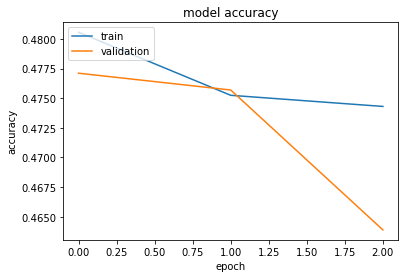

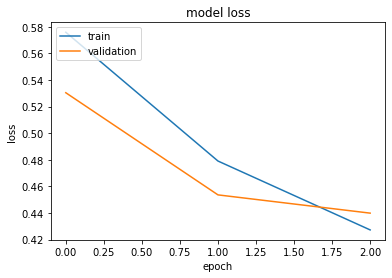

Saved scrambler model at saved_models/subtraction_rs_300_100_lr_001_pooled.h5 


In [7]:
combos = [("subtraction_rs_300_100_lr_001_pooled", 300, 100, 0.001)]

for combo in combos:
    trainEvalAndSaveModel(combo[0], combo[1], combo[2],  combo[3])

In [9]:
#set up datsets
totalSet = pd.read_csv("halfFragozaTestSet.csv")
train, valid, test = setupDataframesForGenerators(totalSet)
print ('train size: ', train.shape)
print ("valid size: ", valid.shape)
print ("test size: ", test.shape)
print (totalSet.columns) #Index(['Unnamed: 0', '1', '2', 'Interacts', 'Type', 'Dataset'], dtype='object')

train size:  (458282, 6)
valid size:  (50732, 6)
test size:  (50737, 6)
Index(['Unnamed: 0', '1', '2', 'Interacts', 'Type', 'Dataset'], dtype='object')


In [10]:
#set up generators 
trainGenerator = GeneratorFromDFUniRep(train,'pooled')
validationGenerator = GeneratorFromDFUniRep(valid,  'pooled')

trianing steps:  14322
validation steps:  1586
Epoch 1/3
14322/14322 [==============================] - 1078s 75ms/step - loss: 0.5630 - acc: 0.4784 - val_loss: 0.6416 - val_acc: 0.4577
Epoch 2/3
14322/14322 [==============================] - 1077s 75ms/step - loss: 0.4596 - acc: 0.4663 - val_loss: 0.6482 - val_acc: 0.4525
Epoch 3/3
14322/14322 [==============================] - 1078s 75ms/step - loss: 0.4069 - acc: 0.4631 - val_loss: 0.7325 - val_acc: 0.3455


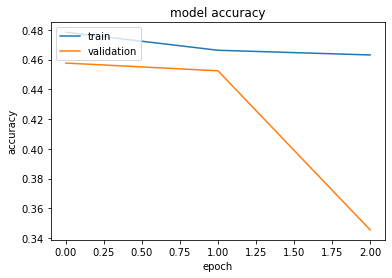

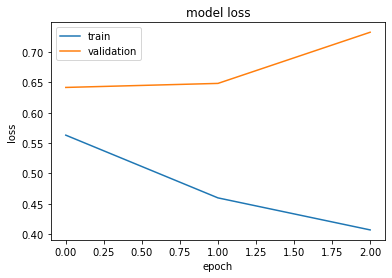

Saved scrambler model at saved_models/subtraction_fs_300_100_lr_001_pooled.h5 


In [11]:
combos = [("subtraction_fs_300_100_lr_001_pooled", 300, 100, 0.001)]

for combo in combos:
    trainEvalAndSaveModel(combo[0], combo[1], combo[2],  combo[3])